# FaceForensics Video Classification using InceptionV3

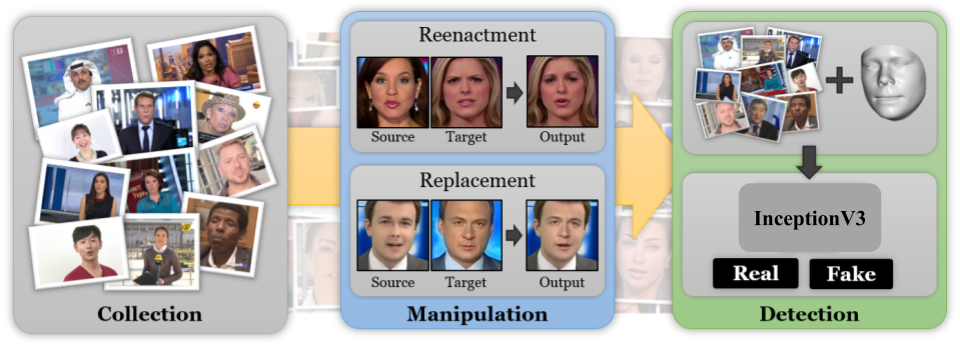

The FaceForensics dataset comprises of 1000 videos which have been manipulated with various face manipulation methods. To classify these videos as real or fake, we will extract frames from the videos so that we can simplify part of this task to an image classification task

## Data preprocessing
Preparing data to train InceptionV3

### Extracting video frames

>> 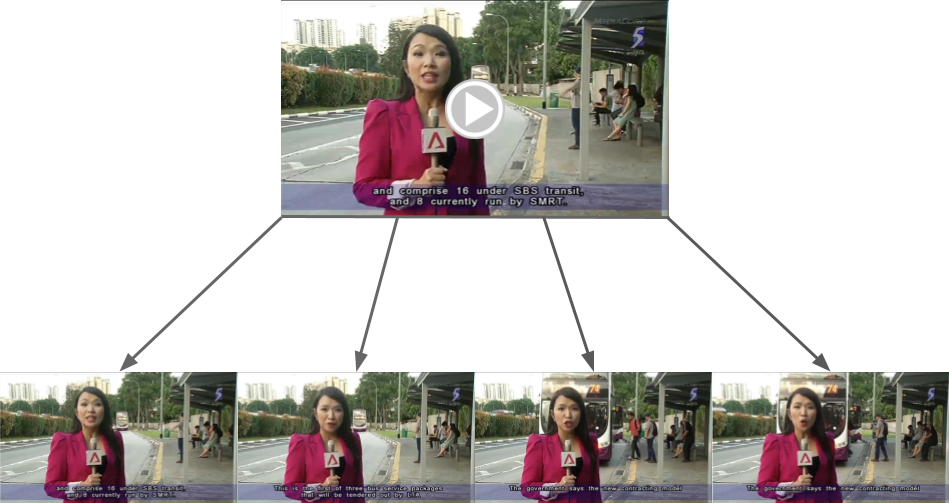

### Face Extraction

> 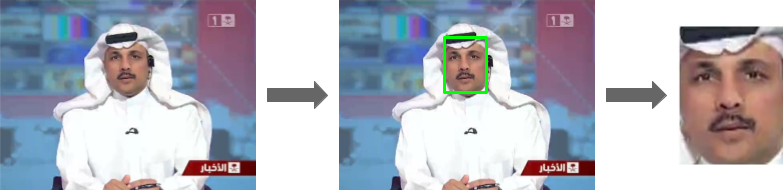

### Data Augmentation

> The FaceForensics dataset contains 5 times more deepfake videos than real videos, leading to dataset imbalance. This is a problem as our model could overfit on the data, for example, by classifying all frames extracted as fake. To resolve this problem, data augmentation can be employed.

> Data augmentation can increase the amount of data we have in the real class by adding slightly modified copies of the existing samples. In this case, we have added greyscale versions of the existing real images and extracted frames at a higher framerate from the real videos to augment the dataset. Other simple methods for data augmentation include random crops of the images, mirroring the images, colour modifications etc. More complex methods include using [Generative Adversarial Networks (GANs)](#GANs) to generate more images.

> 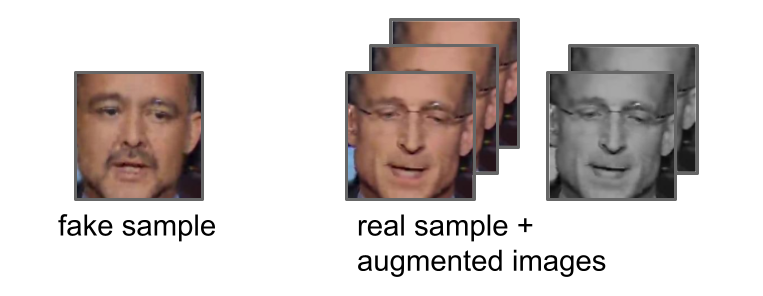

## Classifier

We will be using InceptionV3, which has been pretrained on the ImageNet dataset, to classify the frames extracted from the FaceForensics video dataset

# 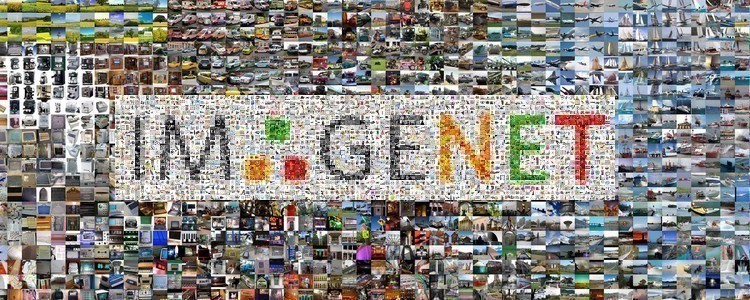

## Import libraries

In [1]:
import numpy as np # for processing of arrays
import pandas as pd
import sklearn # to display model performance on test set
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt # to display images from dataset
import os
from glob import glob
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

# import tensorflow backend and keras api
import tensorflow as tf
import keras
import keras.backend as K

# import model layers and InceptionV3 architecture
from tensorflow.python.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.ensemble import RandomForestClassifier

# import optimizers and callbacks
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

from tensorflow.python.keras.layers import VersionAwareLayers

layers = VersionAwareLayers()
Dropout = layers.Dropout
Dense = layers.Dense
Input = layers.Input
concatenate = layers.concatenate
GlobalAveragePooling2D = layers.GlobalAveragePooling2D
AveragePooling2D = layers.AveragePooling2D
Flatten = layers.Flatten

## Check if CUDA is available
CUDA is a parallel computing platform which can speed up our computations (i.e. train this model much faster!) and can be used on any Nvidia GPU from the G8x series onwards.

If CUDA is unavailable, check that your runtime has been changed to GPU. (Runtime -> Change runtime type -> GPU)

In [2]:
print("GPU:", tf.config.list_physical_devices('GPU'), "\nCUDA Enabled:", tf.test.is_built_with_cuda(), "\nGPU Name:", tf.test.gpu_device_name(), "\nVisible Devices:", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 
CUDA Enabled: True 
GPU Name: /device:GPU:0 
Visible Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17718497143284680292
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18118838587495471470
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Download dataset

In [3]:
!wget -nv -q --show-progress -O ff.zip https://bit.ly/3w0xyBl
!unzip -q ff.zip -d ffdata
!rm ff.zip

ff.zip              100%[===================>]   1.75G  34.9MB/s    in 41s     


In [4]:
# ImageDataGenerator loads images into memory in batches of specified size (in this case 16 images per batch)
# this avoids possible memory issues
train_folder = '/content/ffdata/train'
val_folder = '/content/ffdata/val'
df_train = pd.read_csv(train_folder + '/image_labels.csv')
df_val = pd.read_csv(val_folder + '/image_labels.csv')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # rescaling normalizes pixel values from the range [0,255] to [0,1]
train_set = datagen.flow_from_dataframe(dataframe=df_train, directory=train_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=16)
val_set = datagen.flow_from_dataframe(dataframe=df_val, directory=val_folder, classes= ['real', 'fake'], class_mode="categorical", target_size=(299, 299), batch_size=16)

print("Check class name mapping to label index:")
print(train_set.class_indices)
print(val_set.class_indices)

Found 66722 validated image filenames belonging to 2 classes.
Found 12592 validated image filenames belonging to 2 classes.
Check class name mapping to label index:
{'fake': 0, 'real': 1}
{'fake': 0, 'real': 1}


## Model architecture

InceptionV3 is a convolutional neural network, meaning that it extracts features (in this case, faces and facial features) from input images using matrix operations (convolutions)

### Common Layers used in InceptionV3

#### Convolutional Layer (Conv2D)

> A kernel/filter is applied over the input image to obtain a feature map as output

>>>> 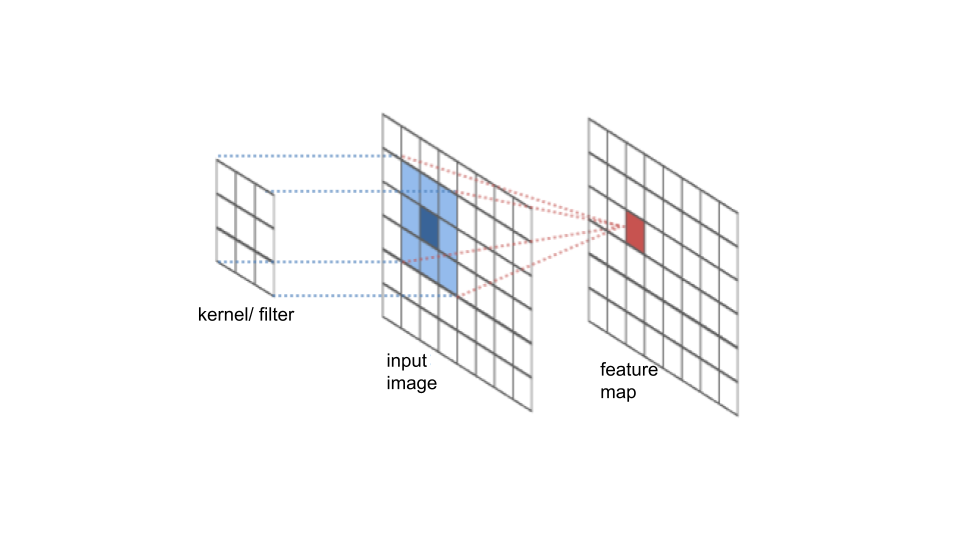

> The filter (in dark blue) is moved over the input image to obtain the feature map (white) as shown below

>>>> 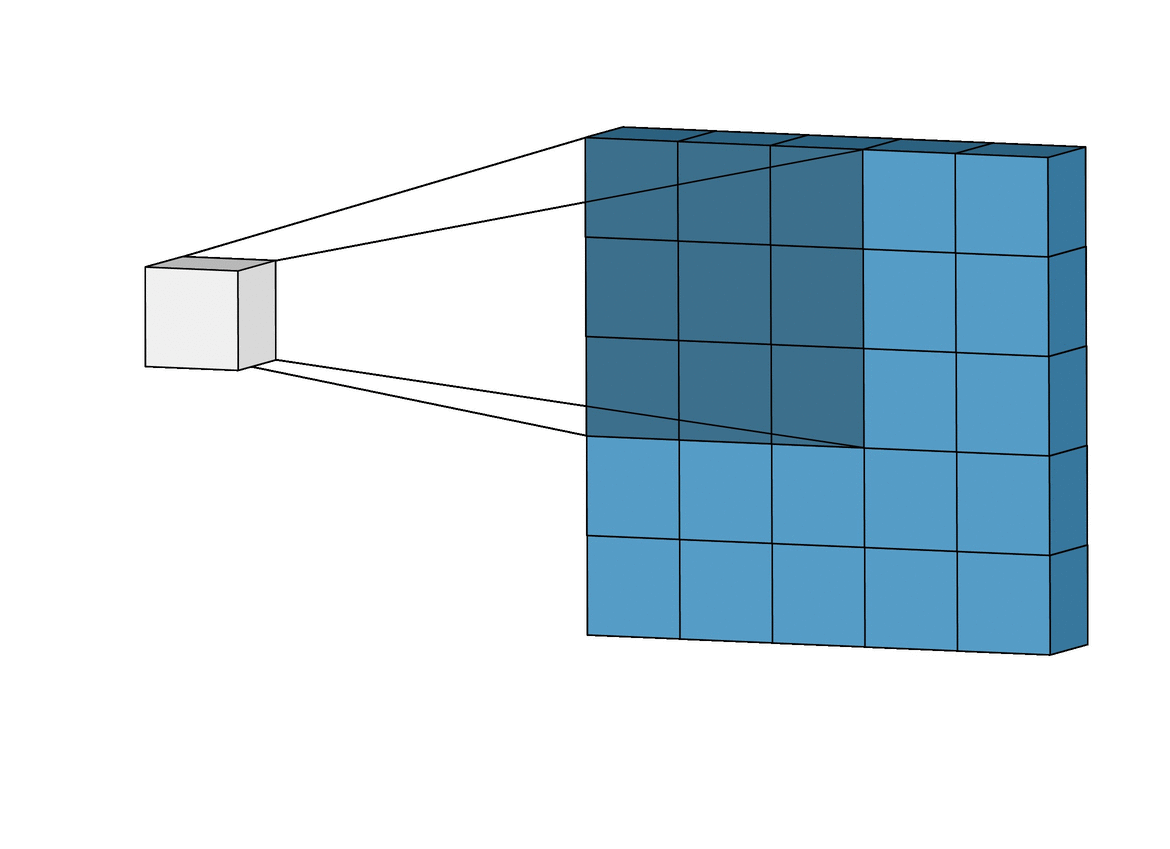

> After the image passes through multiple convolutional layers, feature extraction becomes more complex

> 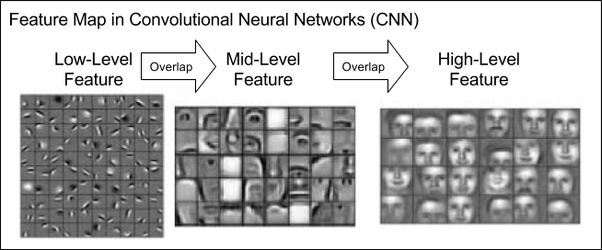

#### Activation Layer (Activation)

> Transforms the input from the node into activation/non-activation of the node. A node is where a computation occurs, so convolutions would occur in a node, and the weighted output of the convolutional layer (feature map) would be the input into the activation layer

>> 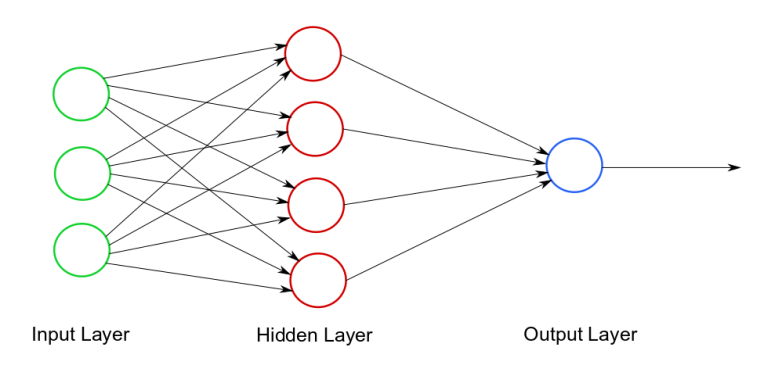

> Note: the hidden layer includes all layers in the model that are not the input or output layers, e.g. convolution and activation layer

> The activation layer uses activation functions, which reside within hidden and output nodes (red and blue circles above), to determine whether to activate the hidden node it is in or not. InceptionV3 uses the [ReLU (Rectified Linear Unit)](#ReLU) activation function.

#### Pooling Layer (MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D)

> Pooling layers help to address limitations of convolutional layers - convolutional layers record the exact position of features in a feature map, so slight shifts in position of the same feature would result in a different feature map. To address this, pooling layers downsample the image (generate a lower resolution version of the feature map).

> Pooling layers
*   Halves size of image by increasing stride length (number of pixels that the filter shifts over the image/feature map each time)
*   Downsamples feature maps, making the resulting feature maps more robust to changes in the position of the feature in the image



>Max Pooling Layer
*   Outputs the maximum value for each filter-sized patch of the feature map



> 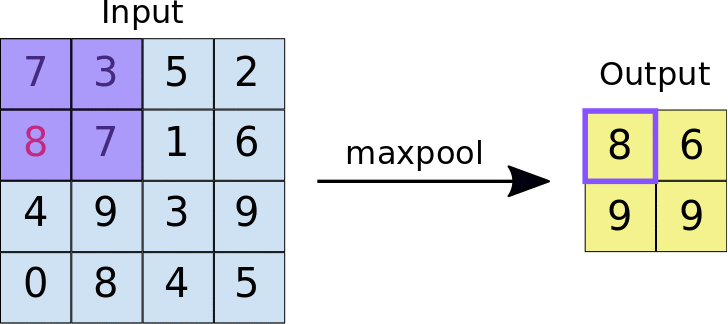

> Average Pooling Layer
*   Outputs the average value for each filter-sized patch of the feature map

> 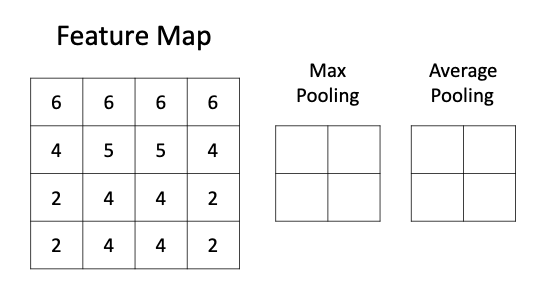

> Global Pooling Layer
*   Downsamples the entire feature map to a single value
*   Used right before output layer

### Load InceptionV3 Pretrained Model
> InceptionV3 documentation: https://keras.io/api/applications/inceptionv3/

In [6]:
base_model = InceptionV3(include_top=False, weights="imagenet", input_tensor=Input(shape=(299,299,3)))
# add global pooling and dense layers to obtain output from the model
layer = base_model
layer = GlobalAveragePooling2D()(layer.output)
layer = Dense(2, activation='softmax', name='output')(layer)
input_layer = base_model.input
model = Model(inputs=input_layer, outputs=layer, name="InceptionV3")

In [7]:
# display model summary
model.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
________________________________________________________________________________________

<a name="Optimisers"></a>
### Optimiser
> Updates model in response to output of loss function (loss function tells the model the error in classification of individual samples)

In [8]:
# optimisers from Keras https://keras.io/api/optimizers/#available-optimizers
sgd = SGD(lr=0.001, momentum=0.9, nesterov=False)
adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False)

#compile model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Inception Module

InceptionV3 is a convolutional neural network using the 3rd iteration of Google's Inception architecture, comprising inception modules which allow it to achieve high classification accuracy at low computation time 

These inception modules perform convolutions with different filter sizes in parallel, stacking the output from all these convolutions together as output

Allows for more efficient computation (shorter training time)

>>>>>> 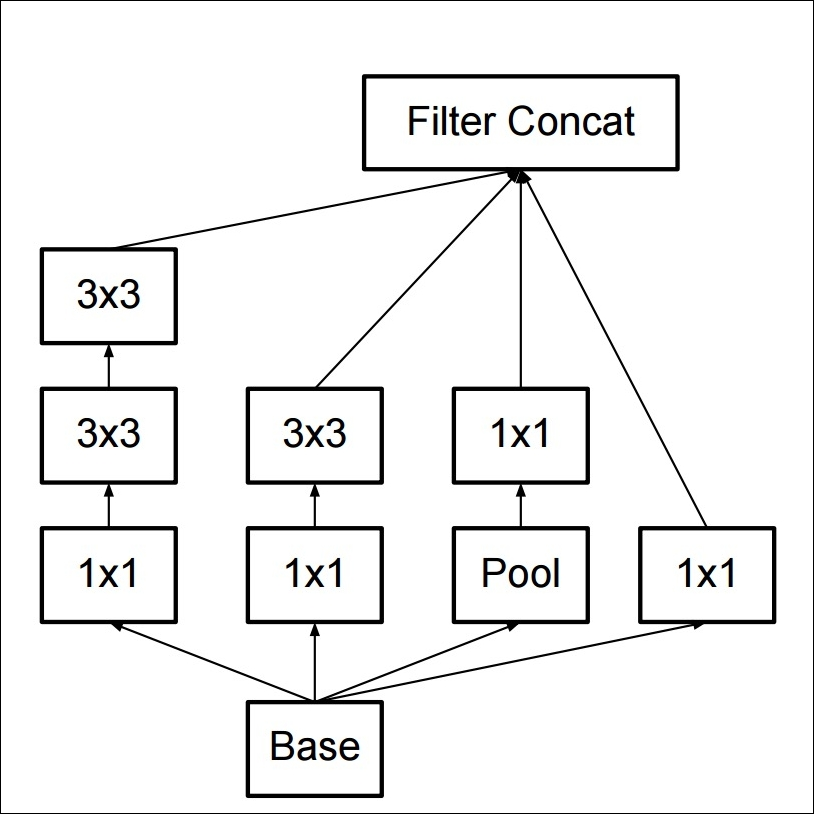

See if you can spot an inception module in the diagram below!

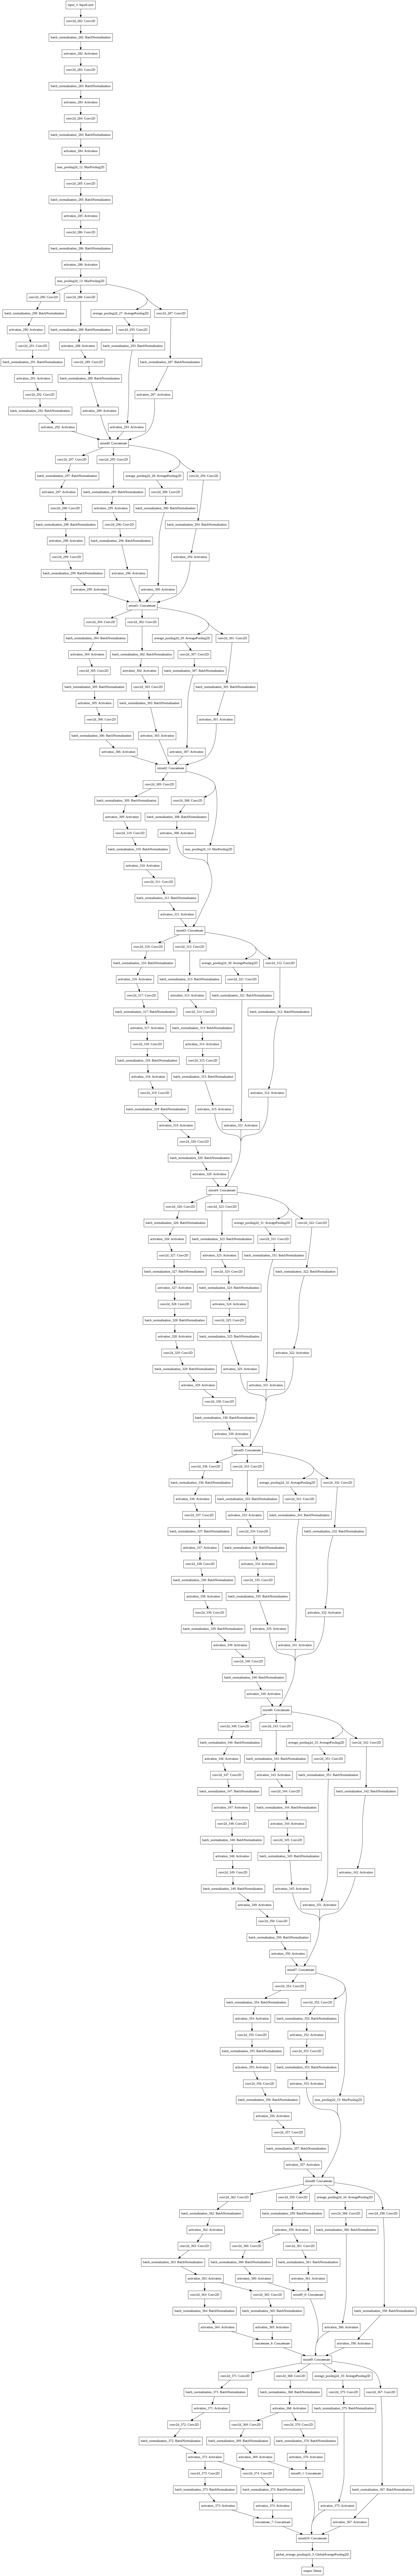

In [ ]:
plot_model(model, to_file='model.png')

## Define callbacks

In [9]:
!mkdir "/content/weights/"

In [10]:
# ModelCheckpoint callback saves the model weights after every epoch (iteration through the dataset)
# if the validation accuracy is higher than that of the model previously saved
checkpoint = ModelCheckpoint("/content/weights/inceptionv3.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## Train model
> Fit the model to the data

In [11]:
hist = model.fit(train_set, steps_per_epoch=16, epochs = 25, validation_data=val_set, validation_steps=8, callbacks = [checkpoint])

Epoch 1/25
16/16 [==============================] - 45s 324ms/step - loss: 0.5463 - accuracy: 0.8125 - val_loss: 0.3963 - val_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.39631, saving model to /content/weights/inceptionv3.h5
Epoch 2/25
16/16 [==============================] - 4s 253ms/step - loss: 0.4953 - accuracy: 0.8242 - val_loss: 0.4798 - val_accuracy: 0.8281

Epoch 00002: val_loss did not improve from 0.39631
Epoch 3/25
16/16 [==============================] - 4s 252ms/step - loss: 0.4461 - accuracy: 0.8438 - val_loss: 0.4735 - val_accuracy: 0.8516

Epoch 00003: val_loss did not improve from 0.39631
Epoch 4/25
16/16 [==============================] - 4s 255ms/step - loss: 0.5449 - accuracy: 0.7617 - val_loss: 0.5366 - val_accuracy: 0.8281

Epoch 00004: val_loss did not improve from 0.39631
Epoch 5/25
16/16 [==============================] - 4s 254ms/step - loss: 0.4201 - accuracy: 0.8555 - val_loss: 0.5735 - val_accuracy: 0.7656

Epoch 00005: val_loss did not i

## Display model training/validation accuracy and loss

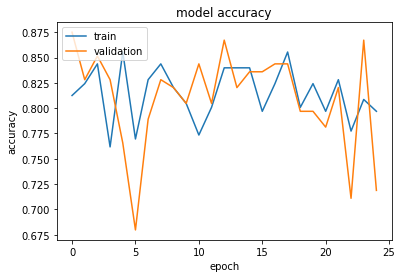

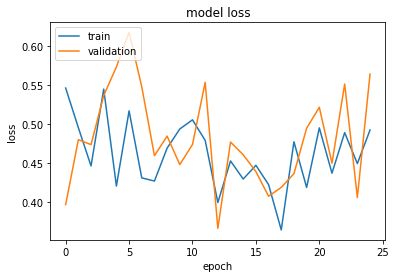

In [12]:
# plot training and validation accuracy against epochs using matplotlib
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss against epochs using matplotlib
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Load Weights

In [13]:
model.load_weights("/content/weights/inceptionv3.h5")

<a name="eval"></a>
## Evaluate Model

To classify the video as real or fake, we will first obtain the model's predictions on each frame extracted from the video. We then take the mean of the prediction (probability) of the frames as the prediction of the video. 

In [14]:
def read_image_from_disk(path):

  """
  Helper function to read image from disk given a absolute path.

  :param path: Absolute path to image file on disk
  :return: Image in Numpy Ndarray representation
  """

  img = tf.keras.preprocessing.image.load_img(path, target_size=(299,299,3))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = img/255
  img = np.expand_dims(img, axis=0)

  return img


def get_frames_to_vid_mapping(frame_list):

  """
  Helper function to generate a mapping of frames to it's corresponding video 
  name.

  The path of frames in the frame_list will be in such format:
  image/[video name]/[frame number].jpg
  e.g. image/00000/00032.jpg

  :param frame_list: A list of paths to the image frames
  :return: A sorted dictionary with keys as the video name and value as the
           corresponding frames.
           e.g. of returned mapping dictionary:

            {
              "00000":[
                  "00032",
                  "00064",
                  .
                  .
                  .
                  "00487"
              ],
              "00001":[
                  "00000",
                  "00032",
                  .
                  .
                  .
                  "00392"
              ],
              .
              .
              .
              "00790":[
                  "00000",
                  "00027",
                  .
                  .
                  .
                  "00542"
              ]
            }
  """

  # Get all videos name
  vidnames = [frame.split("/")[1:2][0] for frame in frame_list]
  # Get only unique names
  vidnames = set(vidnames)
  # Init the mapping dict
  mapping = {vidname: [] for vidname in vidnames}

  # Add frames to to its corresponding list
  for frame in frame_list:
    vidname = str(frame.split("/")[1:2][0])
    frame_number = str(frame.split("/")[-1].split(".")[0])
    mapping[vidname].append(frame_number)

  return dict(sorted(mapping.items()))


def infer_videos(test_data_path, csv_file, num_of_videos='All'):

  """
  Function to infer a test data set. The function takes in a path to the test
  data set and a csv file that contain the paths of the frames extracted from 
  the videos in the test dataset.

  :param test_data_path: Absoulute path to the test dataset
  :param csv_file: File Name of the CSV file that must be in the test_data_path
  :param num_of_videos: Number of videos to infer from the dataset (default: All)
  :return: Pandas dataframe which contains the prediction (probability of being 
           fake) of each video. 
  """

  list_dir = list(pd.read_csv(test_data_path + csv_file).iloc[:,0])

  mapping = get_frames_to_vid_mapping(list_dir)

  # [*mapping] gives the list of keys (video name) in the mapping dict
  num_of_videos_avail = len([*mapping])

  # Set number of videos to be inferred to total of videos available if given 
  # num_of_videos is more than max amount of available videos
  if num_of_videos == 'All' or num_of_videos > num_of_videos_avail:
      num_of_videos = num_of_videos_avail

  # init mapping of videos to its corresponding predicted probabilities
  videos_to_prediction = {}

  # Loop through each video and make a prediction of each frame in the video.
  # Assigned a prediction to each video by taking the mean of its corresponding
  # frames' probabilities.
  for video_name in [*mapping][0:num_of_videos]:

    frames = mapping[video_name]
    predictions = []
    print("Infering video {video}...".format(video=video_name))
    print("Processing frame ", end=" ")

    # Process each frame in video
    for frame in frames:
      print(frame, end =", ")
      frame_path = "image/{video_name}/{frame}.jpg".format(video_name=video_name, frame=frame)
      img = read_image_from_disk(test_data_path + frame_path)
      prediction = model.predict(img)[0]
      # Collect only the 'real' side of probability
      predictions.append(prediction[1])

    # Take the mean of the probabilities from the frames
    videos_to_prediction[video_name] = statistics.mean(predictions)
    print("Done!")
  
  return pd.DataFrame(videos_to_prediction.items())


In [15]:
modelPredictions = infer_videos("/content/ffdata/test/", "image_labels.csv")
print(modelPredictions)

Infering video 00000...
Processing frame  00032, 00064, 00097, 00129, 00162, 00194, 00227, 00259, 00292, 00324, 00357, 00389, 00422, 00454, 00487, Done!
Infering video 00001...
Processing frame  00000, 00032, 00065, 00098, 00130, 00163, 00196, 00228, 00261, 00294, 00326, 00359, 00392, Done!
Infering video 00002...
Processing frame  00000, 00027, 00054, 00081, 00108, 00135, 00162, 00189, 00216, 00243, 00271, 00298, 00325, 00352, 00379, 00406, 00433, 00460, 00487, 00514, 00542, Done!
Infering video 00003...
Processing frame  00000, 00031, 00063, 00095, 00127, 00159, 00191, 00222, 00254, 00286, 00318, 00350, 00382, 00413, 00445, 00477, 00509, 00541, 00573, 00605, Done!
Infering video 00004...
Processing frame  00000, 00026, 00052, 00078, 00105, 00131, 00157, 00183, 00210, 00236, 00262, 00289, 00315, 00341, 00367, 00394, 00420, 00446, 00472, 00499, 00525, 00551, 00578, 00604, 00630, 00656, 00683, 00709, 00735, 00762, Done!
Infering video 00005...
Processing frame  00000, 00025, 00051, 0007

## Submission

In [16]:
modelPredictions.columns = ['vid_name', 'label']
modelPredictions.to_csv("/content/ffdata/model_predictions.csv", index=False)

### Frame Extraction

In [ ]:
def extract_frames(vidPath, savePath):
  for file in os.listdir(vidPath):
    count = 0
    cap = cv2.VideoCapture(vidPath + file)
    frame_rate = 3
    prev = 0
    i = 0
    while cap.isOpened():
      time_elapsed = time.time() - prev
      ret, frame = cap.read()
      if not ret:
        break
      if time_elapsed > 1./frame_rate:
          prev = time.time()
          os.chdir(savePath)
          filename = file + "-frame%d.jpg" % count;count+=1
          cv2.imwrite(filename, frame)
          i += 1
    cap.release()
    cv2.destroyAllWindows()

extract_frames("/content/drive/My Drive/Brainhack FaceForensics Dataset/test/Videos",
               "/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_frames")

### Face Extraction

In [ ]:
def extF(imgPath, savePath):
    for file in os.listdir(imgPath):
        face_detector = dlib.get_frontal_face_detector()
        image = io.imread(imgPath + file)
        detected_faces = face_detector(image, 1)
        face_frames = [(x.left(), x.top(), x.right(), x.bottom()) for x in detected_faces]
        count = 0
        for n, face_rect in enumerate(face_frames):
            os.chdir(savePath)
            face = Image.fromarray(image).crop(face_rect)
            image = np.asanyarray(face)
            filename = file + "-" + str(count) + ".jpg"
            io.imsave(filename, image)
            count += 1
            break

extF("/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_frames", 
     "/content/drive/My Drive/Brainhack FaceForensics Dataset/test/extract_faces")

In [ ]:
# # use keras .predict method to obtain the model's predicted probabilities on each frame for each class
# pred = model.predict(test_set)
# y_predFr = pred
# # obtain the true class of each frame
# y_trueFr = test_set.classes[test_set.index_array]

In [ ]:
# pred = []
# # obtain the class predicted for each frame from probabilities predicted by the model
# for l in range(len(y_predFr)):
#   pred.append(np.argmax(y_predFr[l], axis = 0))
# # get precision, recall and f1-scores for each class
# # to determine if the model is overfitting
# print(classification_report(y_trueFr, pred, target_names=['fake', 'real']))
# # get confusion matrix
# print(confusion_matrix(y_trueFr, pred))
# # get accuracy score
# print("Accuracy: ", accuracy_score(y_trueFr, pred))

              precision    recall  f1-score   support

        fake       0.00      0.00      0.00     12949
        real       0.45      1.00      0.62     10548

    accuracy                           0.45     23497
   macro avg       0.22      0.50      0.31     23497
weighted avg       0.20      0.45      0.28     23497

[[    0 12949]
 [    1 10547]]
Accuracy:  0.4488658126569349


Labels for sklearn confusion matrix (negative corresponds to fake images)

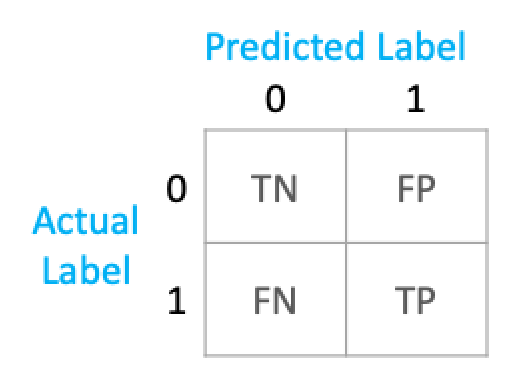

In [ ]:
# # evaluate model
# results = model.evaluate(test_set)

1469/1469 [==============================] - 230s 156ms/step - loss: 0.8730 - accuracy: 0.4489


In [ ]:
# metrics = model.metrics_names
# # display accuracy and loss for model.evaluate
# for i in range(len(metrics)):
#   print(metrics[i], ":", results[i])

loss : 0.8730071187019348
accuracy : 0.4488658010959625


## Try to achieve the highest accuracy you can!
> Possible things to try:
*   [Hyperparameter tuning](https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a) (e.g. number of epochs, batch size etc.)
*   Using different optimisers and tuning their parameters (sgd, adadelta and rmsprop have been included in the code [above](#Optimisers)
*   Using [callbacks](https://keras.io/api/callbacks/#available-callbacks)

## Submit for judging
> Run the cells under [Evaluate Model](#eval) and send the output to your mentor

# Advanced Topics (Optional)

## GANs
<a name="GANs"></a>

>GANs comprise of 2 sub models - the discriminator and generator. The generator aims to generate samples that can fool the discriminator into thinking they are real samples. Over time, the discriminator is unable to distinguish between the real and generated samples, so the discriminator accuracy converges to 50% (no better than randomly guessing classes). Further reading: https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

> State of the art GAN models such as Nvidia StyleGAN2 are able to generate realistic faces. Visit [This Person Does Not Exist](https://thispersondoesnotexist.com/) to see faces generated by this GAN.

> Some faces generated by StyleGAN:

> 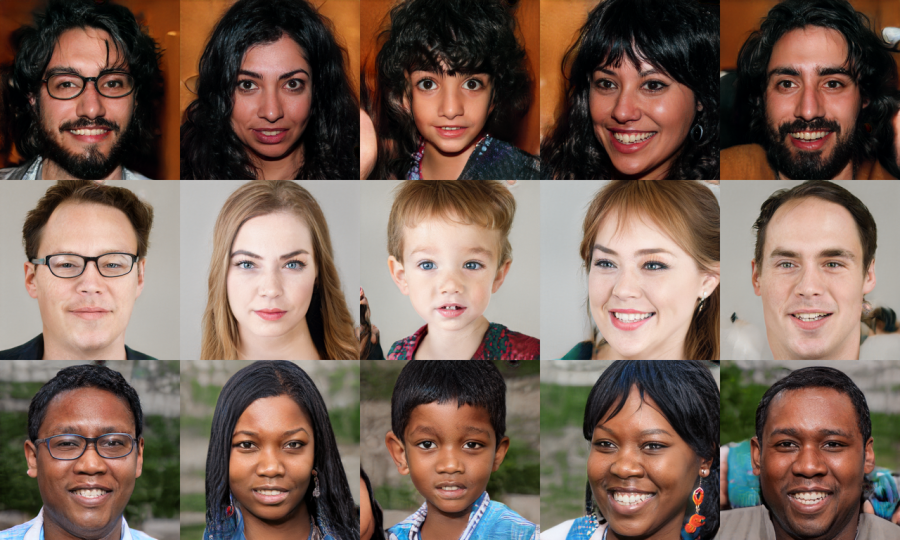

## Activation Layers

> ReLU (Rectified Linear Unit)
<a name="ReLU"></a>

> 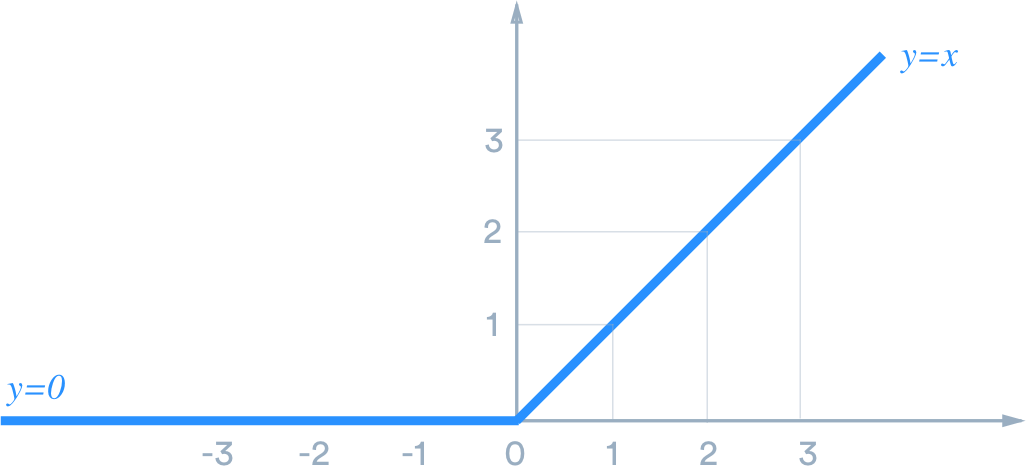

> ReLU is used to combat the vanishing gradient problem due to the limitations of Sigmoid and Tanh activation functions. Further reading: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e

## Optimisers
> Further reading: https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6

> SGD (Stochastic Gradient Descent)
1.   Calculates what a small change in each individual weight would do to the loss function
2.   Adjust individual weight based on gradient of batches/ random samples
3.   Repeat above steps to minimize loss function

> Adam (Adaptive Moment Estimation)
*   Uses past gradients to calculate current gradients
*   Uses concept of momentum by adding fractions of previous gradients to the current one

> Adadelta
*   adapts learning rate to individual features
*   some weights will have different learning rates than others
*   works well for sparse datasets where a lot of input examples are missing
*   adaptive learning rate gets extremely small over time

> RMSprop
*   keeps the moving average of the squared gradients for each weight, divide the gradient by square root the mean square
*   Further reading: https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a

## References

<cite>roessler2019faceforensicspp</cite>
      
> Authors: <cite>‪Andreas Rössler‬ and Davide Cozzolino and Luisa Verdoliva and Christian Riess and Justus Thies and Matthias Nießner</cite>  
Title: <cite>FaceForensics++: Learning to Detect Manipulated Facial Images</cite>  
Booktitle: <cite>International Conference on Computer Vision (ICCV)</cite>  
Year: <cite>2019</cite>
